### Control Station

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# import pivottablejs
# from pivottablejs import pivot_ui
from IPython.display import HTML
import reverse_geocoder as rg
import pycountry
import plotly.graph_objects as go
# from pychord import Chord
import random

In [2]:
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None
pd.options.display.max_colwidth
pd.options.display.float_format = "{:,.0f}".format

### Dataset Exploration

In [3]:
xls = pd.ExcelFile('../../dev_data/carbon_bombs_all_datasets.xlsx', engine='openpyxl')

#### Carbon Bombs Info

In [4]:
cb_info = pd.read_excel(xls, 'carbon_bombs_informations')

In [5]:
cb_info['Potential_GtCO2_source_CB'].sum()

1182.272634207

In [6]:
cb_info['Fuel_type_source_CB'].value_counts()

Coal       230
Oil&Gas    195
Name: Fuel_type_source_CB, dtype: int64

In [7]:
dup_cb = cb_info['Carbon_bomb_name_source_CB'].value_counts().head(4).index.to_list()
dup_cb

['Central Arabian Onshore',
 'Central Arabian Offshore',
 'Eagle Ford Shale',
 'La Luna Shale']

#### Company Info

In [8]:
company_info = pd.read_excel(xls, 'company_informations')

In [9]:
company_info.drop_duplicates(inplace=True)

#### Bank Info

In [10]:
bank_info = pd.read_excel(xls, 'bank_informations')

In [ ]:
# bank_info.pivot_table(columns=['Bank Name'], aggfunc='size')
# bank_info[bank_info['Bank Name'].isin(bank_info['Bank Name'].duplicated())]

In [ ]:
# bank_info_dup = bank_info.pivot_table(columns=['Bank Name'], aggfunc='size')
# bank_info_dup.loc[lambda x: x>1]

#### Bank Company Connection

In [11]:
bank_comp = pd.read_excel(xls, 'connexion_bank_company')

In [12]:
bank_comp_melt = pd.melt(bank_comp, id_vars =['Bank','Company'], value_vars =['2016', '2017', '2018', '2019', '2020', '2021', '2022'],
              var_name ='Year', value_name ='Amount')
bank_comp_melt.head()

,Bank,Company,Year,Amount
0,Agricultural Bank of China,State Grid Corp of China,2016,"772,010,000"
1,Agricultural Bank of China,China National Petroleum Corporation (CNPC),2016,"1,900,240,000"
2,Agricultural Bank of China,China Huadian Corp Ltd,2016,"935,007,190"
3,Agricultural Bank of China,Beijing Energy Holding Co Ltd,2016,"180,670,028"
4,Agricultural Bank of China,Shandong Energy Co Ltd,2016,0


In [13]:
bank_comp_melt_ttl = pd.melt(bank_comp, id_vars =['Bank','Company'], value_vars =['Grand Total'],
              var_name ='Grand Total', value_name ='Amount')
bank_comp_melt_ttl.head()

,Bank,Company,Grand Total,Amount
0,Agricultural Bank of China,State Grid Corp of China,Grand Total,"9,679,477,550"
1,Agricultural Bank of China,China National Petroleum Corporation (CNPC),Grand Total,"10,405,324,300"
2,Agricultural Bank of China,China Huadian Corp Ltd,Grand Total,"4,886,421,111"
3,Agricultural Bank of China,Beijing Energy Holding Co Ltd,Grand Total,"1,201,041,613"
4,Agricultural Bank of China,Shandong Energy Co Ltd,Grand Total,"2,036,359,206"


In [14]:
bank_comp_melt['Amount'].sum()

1069369072677.9813

In [ ]:
# bank_comp_melt.to_csv('../../dev_data/bank_comp_melt.csv')

In [ ]:
# bank_comp_melt_ttl.to_csv('../../dev_data/bank_comp_melt_ttl.csv')

#### CB Company Connection

In [15]:
cb_comp = pd.read_excel(xls, 'connexion_carbonbombs_company')

,Carbon_bomb_name,Company,Percentage
0,ACG (Azeri-Chirag-Guneshli Deep Water),Limited,36
1,ACG (Azeri-Chirag-Guneshli Deep Water),Azerbaijan,12
2,ACG (Azeri-Chirag-Guneshli Deep Water),BP P.L.C.,9
3,ACG (Azeri-Chirag-Guneshli Deep Water),Equinor ASA,11
4,ACG (Azeri-Chirag-Guneshli Deep Water),Others,33


In [ ]:
# cb_bomb_check = cb_comp.groupby(['Carbon_bomb_name']).sum().reset_index()
# cb_bomb_check[cb_bomb_check['Percentage'] > 100]

##### duplication: cb_info

In [16]:
# cb_info dataset is sliced into half:
    # 1 portion - with projects having the same names but operated in different countries, i.e. the 4 projects ['Central Arabian Onshore','Central Arabian Offshore','Eagle Ford Shale','La Luna Shale'] and 
    # 1 portion - for the rest of the data
# The purpose of this action is for pd.merge function to work later, if not, the resulting dataset after any merge will have many duplication
# For example: when connexion_carbonbombs_company (Eagle Ford Shale to 2 companies) is merged with carbonbombs_information (Eagle Ford Shale to 2 sites of extraction), the merge will result into 4 rows while we only need 2 rows that show the % share of the company matched to the total GtCO2 emissions by a project)

name = ['Central Arabian Offshore',
 'Central Arabian Onshore',
 'Eagle Ford Shale',
 'La Luna Shale']
cb_info_nondup = cb_info[~cb_info['Carbon_bomb_name_source_CB'].isin(name)]
cb_info_nondup = cb_info_nondup[['New_project_source_CB', 'Carbon_bomb_name_source_CB', 'Potential_GtCO2_source_CB']]

In [17]:
cb_info_dup = cb_info[cb_info['Carbon_bomb_name_source_CB'].isin(name)]
cb_info_dup = cb_info_dup[['New_project_source_CB', 'Carbon_bomb_name_source_CB', 'Potential_GtCO2_source_CB']]
cb_info_dup['Company'] = 'No informations on company'
cb_info_dup['Percentage'] = 100
cb_info_dup= cb_info_dup[['New_project_source_CB', 'Carbon_bomb_name_source_CB', 'Company', 'Percentage', 'Potential_GtCO2_source_CB']]

In [18]:
cb_info_dup.loc[cb_info_dup['Carbon_bomb_name_source_CB'] == 'Central Arabian Offshore', 'Company'] = 'New Project'
cb_info_dup.loc[cb_info_dup['Carbon_bomb_name_source_CB'] == 'La Luna Shale', 'Company'] = 'New Project'

In [19]:
cb_info_nondup['Potential_GtCO2_source_CB'].sum() + cb_info_dup['Potential_GtCO2_source_CB'].sum()

1182.272634207

#### Geolocation

In [ ]:
def get_country(lat, lon):
    location = rg.search((lat, lon))
    return location[0]['cc']

In [ ]:
company_info['Company_Country'] = company_info.apply(lambda row: get_country(row['Latitude'], row['Longitude']), axis=1)

In [ ]:
company_info.rename(columns={"Company_Country": "Company_CC"}, inplace=True)
company_info.head(1)

In [ ]:
def get_country_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except AttributeError:
        return 'Unknown'

In [ ]:
company_info['Company_Country'] = company_info['Company_CC'].apply(get_country_name)
company_info.head(1)

In [ ]:
coordinates = list(zip(bank_info['Latitude'], bank_info['Longitude']))
results = rg.search(coordinates)
countries = [result['cc'] for result in results]
bank_info['Bank_CC'] = countries
bank_info['Bank_Country'] = bank_info['Bank_CC'].apply(get_country_name)
bank_info.head(1)

In [ ]:
company_info[company_info['Company_Country'].str.contains("Iran")]
company_info.loc[4, "Company_Country"] = "Iran"

In [ ]:
company_info[company_info['Company_Country'].str.contains("Venezuela")]
company_info.loc[196, "Company_Country"] = "Venezuela"
company_info.loc[199, "Company_Country"] = "Venezuela"

In [ ]:
cb_info[cb_info['Country_source_CB'].str.contains("Türkiye")]
cb_info.loc[2, "Country_source_CB"] = "Turkey"

In [ ]:
cb_info[cb_info['Country_source_CB'].str.contains("Kuwait")]
cb_info.loc[179, "Country_source_CB"] = "Kuwait"

In [ ]:
bank_info[bank_info['Bank_Country'].str.contains("Russian")]
bank_info.loc[bank_info['Bank_Country'] == 'Russian Federation','Bank_Country'] = 'Russia'

In [ ]:
bank_info.drop_duplicates()

In [ ]:
# company_info.to_csv('../../dev_data/company_informations_cc.cvs')
# bank_info.to_csv("../../dev_data/bank_informations_cc.csv")

##### var - country_to_zone

In [20]:
country_to_zone = {
    'Afghanistan': 'Asia',
    'Albania': 'Europe',
    'Algeria': 'Africa',
    'Andorra': 'Europe',
    'Angola': 'Africa',
    'Antigua and Barbuda': 'North America',
    'Argentina': 'South America',
    'Armenia': 'Asia',
    'Australia': 'Oceania',
    'Austria': 'Europe',
    'Azerbaijan': 'Asia',
    'Bahamas': 'North America',
    'Bahrain': 'Asia',
    'Bangladesh': 'Asia',
    'Barbados': 'North America',
    'Belarus': 'Europe',
    'Belgium': 'Europe',
    'Belize': 'North America',
    'Benin': 'Africa',
    'Bhutan': 'Asia',
    'Bolivia': 'South America',
    'Bosnia and Herzegovina': 'Europe',
    'Botswana': 'Africa',
    'Brazil': 'South America',
    'Brunei': 'Asia',
    'Bulgaria': 'Europe',
    'Burkina Faso': 'Africa',
    'Burundi': 'Africa',
    'Cabo Verde': 'Africa',
    'Cambodia': 'Asia',
    'Cameroon': 'Africa',
    'Canada': 'North America',
    'Central African Republic': 'Africa',
    'Chad': 'Africa',
    'Chile': 'South America',
    'China': 'China',
    'Colombia': 'South America',
    'Comoros': 'Africa',
    'Congo': 'Africa',
    'Costa Rica': 'North America',
    'Croatia': 'Europe',
    'Cuba': 'North America',
    'Cyprus': 'Asia',
    'Czech Republic': 'Europe',
    'Denmark': 'Europe',
    'Djibouti': 'Africa',
    'Dominica': 'North America',
    'Dominican Republic': 'North America',
    'Ecuador': 'South America',
    'Egypt': 'Africa',
    'El Salvador': 'North America',
    'Equatorial Guinea': 'Africa',
    'Eritrea': 'Africa',
    'Estonia': 'Europe',
    'Eswatini': 'Africa',
    'Ethiopia': 'Africa',
    'Fiji': 'Oceania',
    'Finland': 'Europe',
    'France': 'Europe',
    'Gabon': 'Africa',
    'Gambia': 'Africa',
    'Georgia': 'Asia',
    'Germany': 'Europe',
    'Ghana': 'Africa',
    'Greece': 'Europe',
    'Grenada': 'North America',
    'Guatemala': 'North America',
    'Guinea': 'Africa',
    'Guinea-Bissau': 'Africa',
    'Guyana': 'South America',
    'Haiti': 'North America',
    'Honduras': 'North America',
    'Hungary': 'Europe',
    'Iceland': 'Europe',
    'India': 'Asia',
    'Indonesia': 'Asia',
    'Iran': 'Asia',
    'Iraq': 'Asia',
    'Ireland': 'Europe',
    'Israel': 'Asia',
    'Italy': 'Europe',
    'Jamaica': 'North America',
    'Japan': 'Asia',
    'Jordan': 'Asia',
    'Kazakhstan': 'Asia',
    'Kenya': 'Africa',
    'Kiribati': 'Oceania',
    'Kuwait': 'Asia',
    'Kyrgyzstan': 'Asia',
    'Laos': 'Asia',
    'Latvia': 'Europe',
    'Lebanon': 'Asia',
    'Lesotho': 'Africa',
    'Liberia': 'Africa',
    'Libya': 'Africa',
    'Liechtenstein': 'Europe',
    'Lithuania': 'Europe',
    'Luxembourg': 'Europe',
    'Madagascar': 'Africa',
    'Malawi': 'Africa',
    'Malaysia': 'Asia',
    'Maldives': 'Asia',
    'Mali': 'Africa',
    'Malta': 'Europe',
    'Marshall Islands': 'Oceania',
    'Mauritania': 'Africa',
    'Mauritius': 'Africa',
    'Mexico': 'North America',
    'Micronesia': 'Oceania',
    'Moldova': 'Europe',
    'Monaco': 'Europe',
    'Mongolia': 'Asia',
    'Montenegro': 'Europe',
    'Morocco': 'Africa',
    'Mozambique': 'Africa',
    'Myanmar': 'Asia',
    'Namibia': 'Africa',
    'Nauru': 'Oceania',
    'Nepal': 'Asia',
    'Netherlands': 'Europe',
    'New Zealand': 'Oceania',
    'Nicaragua': 'North America',
    'Niger': 'Africa',
    'Nigeria': 'Africa',
    'North Korea': 'Asia',
    'North Macedonia': 'Europe',
    'Norway': 'Europe',
    'Oman': 'Asia',
    'Pakistan': 'Asia',
    'Palau': 'Oceania',
    'Panama': 'North America',
    'Papua New Guinea': 'Oceania',
    'Paraguay': 'South America',
    'Peru': 'South America',
    'Philippines': 'Asia',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Qatar': 'Asia',
    'Romania': 'Europe',
    'Russia': 'Europe',
    'Rwanda': 'Africa',
    'Saint Kitts and Nevis': 'North America',
    'Saint Lucia': 'North America',
    'Saint Vincent and the Grenadines': 'North America',
    'Samoa': 'Oceania',
    'San Marino': 'Europe',
    'Sao Tome and Principe': 'Africa',
    'Saudi Arabia': 'Asia',
    'Senegal': 'Africa',
    'Serbia': 'Europe',
    'Seychelles': 'Africa',
    'Sierra Leone': 'Africa',
    'Singapore': 'Asia',
    'Slovakia': 'Europe',
    'Slovenia': 'Europe',
    'Solomon Islands': 'Oceania',
    'Somalia': 'Africa',
    'South Africa': 'Africa',
    'South Korea': 'Asia',
    'South Sudan': 'Africa',
    'Spain': 'Europe',
    'Sri Lanka': 'Asia',
    'Sudan': 'Africa',
    'Suriname': 'South America',
    'Sweden': 'Europe',
    'Switzerland': 'Europe',
    'Syria': 'Asia',
    'Taiwan': 'Asia',
    'Tajikistan': 'Asia',
    'Tanzania': 'Africa',
    'Thailand': 'Asia',
    'Timor-Leste': 'Asia',
    'Togo': 'Africa',
    'Tonga': 'Oceania',
    'Trinidad and Tobago': 'North America',
    'Tunisia': 'Africa',
    'Turkey': 'Asia',
    'Turkmenistan': 'Asia',
    'Tuvalu': 'Oceania',
    'Uganda': 'Africa',
    'Ukraine': 'Europe',
    'United Arab Emirates': 'Asia',
    'United Kingdom': 'Europe',
    'United States': 'United States',
    'Uruguay': 'South America',
    'Uzbekistan': 'Asia',
    'Vanuatu': 'Oceania',
    'Vatican City': 'Europe',
    'Venezuela': 'South America',
    'Vietnam': 'Asia',
    'Yemen': 'Asia',
    'Zambia': 'Africa',
    'Zimbabwe': 'Africa',
    'Russian Federation': 'Europe', 
    'Iran, Islamic Republic of': 'Asia',
    'Hong Kong' : 'Asia', 
    'Venezuela, Bolivarian Republic of': 'South America', 
    'Türkiye': 'Asia',
    "Korea, Democratic People's Republic of" : 'Asia', 
    'Kuwait-Saudi Arabia': 'Asia',
    'Korea, Republic of': 'Asia',
    np.nan: "No Information",
    "NaN" : "No Information"
}


##### file - company_info & bank_info

In [21]:
bank_info = pd.read_csv("../../dev_data/bank_informations_cc.csv")
company_info = pd.read_csv('../../dev_data/company_informations_cc.cvs')

##### file - entity_zone

In [31]:
entity_zone = pd.read_csv('../../dev_data/entity_zone.csv')
entity_zone.head()

,Unnamed: 0,Entity,Country,Zone
0,0,ABN AMRO,Netherlands,Europe
1,1,ANZ,Australia,Oceania
2,2,ASN Bank,Netherlands,Europe
3,3,Absa Group,South Africa,Africa
4,4,Access Bank,Nigeria,Africa


### GtCO2 distribution by status by company

#### Merging cb_info to cb_comp to calculate % share of GtCO2 by companies

In [32]:
company_info[company_info['Carbon_bomb_connected'].isnull()].count()

Unnamed: 0                             82
Company_name                           82
Address_headquarters_source_chatGPT    82
Latitude                               82
Longitude                              82
Carbon_bomb_connected                   0
Company_CC                             82
Company_Country                        82
dtype: int64

In [40]:
cb_comp_co2 = cb_comp.merge(cb_info_nondup, how = "left", left_on= "Carbon_bomb_name", right_on="Carbon_bomb_name_source_CB")

In [41]:
# cb_comp includes projects with the same name, when merge with cb_info_nondup, these companies are still present ==> Filter out these company so it does not generate error for next merge
cb_comp_co2 = cb_comp_co2[~cb_comp_co2['Carbon_bomb_name'].isin(name)]

In [42]:
cb_comp_co2['Potential_GtCO2_source_CB'].sum()

2048.899830323

In [43]:
cb_comp_co2.columns
# drop column Carbon_bomb_name_source_CB:
cb_comp_co2 = cb_comp_co2[['New_project_source_CB', 'Carbon_bomb_name', 'Company', 'Percentage', 'Potential_GtCO2_source_CB']]

In [44]:
cb_info_dup.columns = ['New_project_source_CB', 'Carbon_bomb_name', 'Company', 'Percentage',
       'Potential_GtCO2_source_CB']

In [45]:
cb_comp_co2_full = pd.concat((cb_comp_co2,cb_info_dup), axis=0)

In [46]:
cb_comp_co2_full['Potential_GtCO2_source_CB'].sum()

2085.775209756

In [47]:
# Calculate the GtCO2 that's proportionate to the share of company within a project

cb_comp_co2_full['GtCO2_by_Company'] = cb_comp_co2_full['Percentage'] * cb_comp_co2_full['Potential_GtCO2_source_CB'] / 100

In [48]:
cb_comp_co2_full['GtCO2_by_Company'].sum()

1182.272634207

#### Merging cb_comp_co2 to comp_info to identify the country/ location of the company

In [50]:
company_info_sliced = company_info[['Company_name', 'Company_Country']]
company_info_sliced.drop_duplicates(inplace=True)

In [51]:
# Add Company's Country to the dataframe
cb_comp_co2_ctry = cb_comp_co2_full.merge(company_info_sliced, how = 'left', left_on='Company', right_on='Company_name')

In [52]:
cb_comp_co2_ctry['Potential_GtCO2_source_CB'].sum()
# This (2085 GtCO2) is bigger than 1182 because it is mapped into country with shares in the project. Once taking into proportion of share, the total GtC02 of 425 projects will be 1182.

2085.775209756

In [ ]:
# cb_comp_co2_c = pd.DataFrame(cb_comp_co2['Company'])
# cb_comp_co2_c['Source'] = "cb_comp_sheet"
# company_info_c = pd.DataFrame(company_info['Company_name'])
# company_info_c['Source'] = 'company_info_sheet'
# company_info_c.columns = ['Company', "Source"]
# company_name_check = pd.concat([cb_comp_co2_c,company_info_c], axis=0)

In [ ]:
# company_name_check.pivot_table(index=['Company', 'Source'], aggfunc= 'size')
# pd.crosstab(index = company_name_check.Company, columns = company_name_check.Source, margins = True)['cb_comp_sheet'].value_counts()

In [ ]:
# cb_comp_co2_ctry[cb_comp_co2_ctry.Company_Country.isnull()]['Company'].value_counts()

In [ ]:
# cb_comp_co2_ctry_check = cb_comp_co2_ctry[cb_comp_co2_ctry['Company'] != cb_comp_co2_ctry['Company_name']]

In [ ]:
# country_dup = pd.concat([cb_comp_co2_ctry_check['Company'],cb_comp_co2_ctry_check['Company_name']], axis = 0)

In [57]:
# nan_data - Manual input for company without Country information
nan_data = [
    "China Energy Investment Corp Ltd: China",
    "TotalEnergies SE: France",
    "China Coal Xinji Energy Co Ltd: China",
    "Shaanxi Coal and Chemical Industry Group Co Ltd: China",
    "Jinneng Holding Group Co Ltd: China",
    "Coal India Ltd: India",
    "China National Petroleum Corporation (CNPC): China",
    "Shandong Energy Co Ltd: China",
    "Gazprom PJSC: Russia",
    "Exxon Mobil Corp: United States",
    "China Huaneng Group Co Ltd: China",
    "Mitsubishi Corp: Japan",
    "Shell PLC: United Kingdom",
    "Glencore PLC: Switzerland",
    "Shaanxi Investment Group Co Ltd: China",
    "BHP Group Ltd: Australia",
    "Petróleo Brasileiro SA – Petrobras: Brazil",
    "Shenmu City State-Owned Assets Operation Co: China",
    "China Huadian Corp Ltd: China",
    "Huayang New Material Technology Group Co Ltd: China",
    "Shaanxi Yulin Energy Group Co Ltd: China",
    "Shanxi Coking Coal Group Co Ltd: China",
    "Inner Mongolia Yitai Investment Co Ltd: China",
    "China Datang Corp: China",
    "Shaanxi Yanchang Petroleum Group Co Ltd: China",
    "Beijing Energy Holding Co Ltd: China",
    "Chevron Corp: United States",
    "Shougang Group Co Ltd: China",
    "Kuwait Petroleum Corp: Kuwait",
    "Teck Resources Ltd: Canada",
    "Pertamina Persero PT: Indonesia",
    "State Grid Corp of China: China",
    "Inpex Corp: Japan",
    "Shenergy Group Co Ltd: China",
    "Reliance Power Ltd: India",
    "Indonesia Asahan Aluminium Persero PT: Indonesia",
    "Guangdong Hengjian Investment Holding Co Ltd: China",
    "Inner Mongolia Mengtai Group Co Ltd: China",
    "Hubei Yihua Chemical Industry Co Ltd: China",
    "Peabody Energy Corp: United States",
    "AGL Energy Ltd: Australia",
    "Evraz PLC: United Kingdom",
    "China ZhenHua Oil Co Ltd: China",
    "Kailuan Group Ltd Liability Corp: China",
    "Indian Oil Corp Ltd: India",
    "Suncor Energy Inc: Canada",
    "Sojitz Corp: Japan",
    "Thungela Resources Ltd: South Africa",
    "Yangcheng County Yangtai Group Industrial Co Ltd: China",
    "Bulgarian Energy Holding EAD: Bulgaria",
    "Indika Energy Tbk PT: Indonesia",
    "Titan Infra Energy PT: Indonesia",
    "Lu'an Chemical Group Co Ltd: China",
    "Lu'an Chemical Group: China",
    "Rosneftegaz AO: Russia",
    "Elion Resources Group Ltd: China",
    "Delek Group Ltd: Israel",
    "NTPC Ltd: India",
    "POSCO Holdings Inc: South Korea",
    "Bayan Resources Tbk PT: Indonesia",
    "Alliance Resource Partners LP: United States",
    "Exxaro Resources Ltd: South Africa",
    "ITOCHU Corp: Japan",
    "Zhejiang Provincial Energy Group Co Ltd: China",
    "Guangdong Hanjian Investment Co Ltd: China",
    "PPL Corp: United States",
    "China COSCO Shipping Corp Ltd: China",
    "Petróleos Mexicanos (PEMEX): Mexico",
    "Jizhong Energy Group Co Ltd: China",
    "Arch Resources Inc: United States",
    "Occidental Petroleum Corp: United States",
    "Harbour Energy PLC: United Kingdom",
    "Tianjin Energy Investment Co Ltd: China",
    "Xin Jiang Guang Hui Industry Investment Group Co Ltd: China",
    "Maharashtra State Power Generation Company Limited : India"
]

nan_data = [line.split(":") for line in nan_data]
nan_data = pd.DataFrame(nan_data, columns=['Company','Company_Country'])
nan_data = nan_data.applymap(str.strip)

##### var - cb_comp_co2_ctry

In [53]:
cb_comp_co2_ctry_2 = cb_comp_co2_ctry.copy()

##### def - lookup_country

In [58]:
def lookup_country(row):
    matching_rows = nan_data[nan_data['Company'] == row['Company']]
    if matching_rows.empty:
        return row['Company_Country']
    else:
        return matching_rows['Company_Country'].iloc[0]

In [59]:
cb_comp_co2_ctry_2.loc[cb_comp_co2_ctry_2['Company'] == 'an Chemical Group', 'Company'] = "Lu'an Chemical Group"

In [60]:
cb_comp_co2_ctry_2['Company_Country'] = cb_comp_co2_ctry.apply(lookup_country, axis=1)

In [61]:
# cb_comp_co2_ctry_2[cb_comp_co2_ctry_2['Company_Country'].isnull()]['Company'].value_counts()

No informations on company    79
Others                        77
New project                   44
New Project                    5
Other                          4
Investment Group               2
other                          2
Ltd.                           2
Limited                        1
Private individuals            1
Mineralogy                     1
Lu'an Chemical Group           1
S.A.                           1
Private Resources Limited      1
Suncor                         1
Name: Company, dtype: int64

In [62]:
cb_comp_co2_ctry_2['GtCO2_by_Company'] = cb_comp_co2_ctry_2['Potential_GtCO2_source_CB'] * cb_comp_co2_ctry_2['Percentage'] /100

In [63]:
cb_comp_co2_ctry_2['GtCO2_by_Company'].sum()

1182.272634207

In [344]:
cb_comp_co2_ctry_2.columns

Index(['Unnamed: 0', 'New_project_source_CB', 'Carbon_bomb_name', 'Company',
       'Percentage', 'Potential_GtCO2_source_CB', 'GtCO2_by_Company',
       'Company_name', 'Company_Country'],
      dtype='object')

In [64]:
cb_comp_co2_ctry_2[cb_comp_co2_ctry_2['Company_Country'].isnull()]['GtCO2_by_Company'].sum()

# This means that, after cleaning (assigning country to company without initial information, as much as possible), we still cannot account for 531 GtCO2 due to having no information on companies. Total Potential GtCO2 by 425 bombs = 1182.27 ==> almost half of information lost when charting GtCO2 by HQ of the company

532.479311761865

##### file - cb_comp_co2_ctry_2

In [65]:
# cb_comp_co2_ctry_2.to_csv('../../dev_data/connexion_carbonbombs_company_companycountry.csv')

In [66]:
cb_comp_co2_ctry_2 = pd.read_csv('../../dev_data/connexion_carbonbombs_company_companycountry.csv')
cb_comp_co2_ctry_2.head()

,Unnamed: 0,New_project_source_CB,Carbon_bomb_name,Company,Percentage,Potential_GtCO2_source_CB,GtCO2_by_Company,Company_name,Company_Country
0,0,False,ACG (Azeri-Chirag-Guneshli Deep Water),Limited,36,2,1,NaN,NaN
1,1,False,ACG (Azeri-Chirag-Guneshli Deep Water),Azerbaijan,12,2,0,Azerbaijan,Azerbaijan
2,2,False,ACG (Azeri-Chirag-Guneshli Deep Water),BP P.L.C.,9,2,0,BP P.L.C.,United Kingdom
3,3,False,ACG (Azeri-Chirag-Guneshli Deep Water),Equinor ASA,11,2,0,Equinor ASA,Norway
4,4,False,ACG (Azeri-Chirag-Guneshli Deep Water),Others,33,2,1,NaN,NaN


#### Data - parameters for charts

In [68]:
GtCO2_by_country = cb_info.groupby(['Country_source_CB'])['Potential_GtCO2_source_CB'].sum()
GtCO2_by_country = pd.DataFrame(GtCO2_by_country).reset_index()
# GtCO2_by_country.head()

In [69]:
GtCO2_by_country_status = cb_info.groupby(['Country_source_CB','New_project_source_CB'])['Potential_GtCO2_source_CB'].sum()
GtCO2_by_country_status.sort_values(ascending=False)
GtCO2_by_country_status = pd.DataFrame(GtCO2_by_country_status).reset_index()
GtCO2_by_country_status['Label'] = "Site of Extraction"
GtCO2_by_country_status.columns = ['Country', 'New Project', 'GtCO2', 'Label']
GtCO2_by_country_status.head()

,Country,New Project,GtCO2,Label
0,Algeria,False,3,Site of Extraction
1,Algeria,True,2,Site of Extraction
2,Argentina,False,5,Site of Extraction
3,Australia,False,19,Site of Extraction
4,Australia,True,28,Site of Extraction


In [70]:
GtCO2_by_country['Label'] = 'Site of Extraction'
GtCO2_by_country.columns = ['Country', 'GtCO2', 'Label']

In [71]:
GtCO2_by_country['GtCO2'].sum()

1182.272634207

In [72]:
GtCO2_by_company = cb_comp_co2_ctry_2[['Company_Country','GtCO2_by_Company']]
GtCO2_by_company = GtCO2_by_company.groupby(by = 'Company_Country', dropna = False).sum().reset_index()
GtCO2_by_company = pd.DataFrame(GtCO2_by_company)
GtCO2_by_company['Label'] =  "Company HQ"
GtCO2_by_company.columns = ['Country', 'GtCO2', 'Label']

In [73]:
GtCO2_by_company['GtCO2'].sum()

1182.272634207

In [74]:
GtCO2_by_company_status = cb_comp_co2_ctry_2[['Company_Country', "New_project_source_CB", 'GtCO2_by_Company']]
GtCO2_by_company_status = GtCO2_by_company_status.groupby(by =['Company_Country', "New_project_source_CB"], dropna = False).sum().reset_index()
GtCO2_by_company_status = pd.DataFrame(GtCO2_by_company_status)
GtCO2_by_company_status['Label'] =  "Company HQ"
GtCO2_by_company_status.columns = ['Country', "New Project",'GtCO2', 'Label']

In [75]:
GtCO2_by_company_status['Share'] = (GtCO2_by_company_status['GtCO2']/GtCO2_by_company_status['GtCO2'].sum())
GtCO2_by_country_status['Share'] = (GtCO2_by_country_status['GtCO2']/GtCO2_by_country_status['GtCO2'].sum())
GtCO2_by_company_status.style.format({'Share': "{:.2%}"})
GtCO2_by_country_status.style.format({'Share': "{:.2%}"})

,Country,New Project,GtCO2,Label,Share
0,Algeria,False,3.487466,Site of Extraction,0.29%
1,Algeria,True,2.347867,Site of Extraction,0.20%
2,Argentina,False,5.177782,Site of Extraction,0.44%
3,Australia,False,18.797049,Site of Extraction,1.59%
4,Australia,True,27.521628,Site of Extraction,2.33%
5,Azerbaijan,False,1.660266,Site of Extraction,0.14%
6,Bahrain,True,1.411445,Site of Extraction,0.12%
7,Bangladesh,True,1.396069,Site of Extraction,0.12%
8,Botswana,True,2.179548,Site of Extraction,0.18%
9,Brazil,False,7.471032,Site of Extraction,0.63%


In [76]:
GtCO2_distribution = pd.concat([GtCO2_by_company_status, GtCO2_by_country_status], axis=0)

In [77]:
GtCO2_distribution['Zone'] = GtCO2_distribution['Country'].map(country_to_zone)

In [78]:
GtCO2_distribution.loc[GtCO2_distribution['Country'].isnull(), 'Zone'] = "No Information"

In [79]:
GtCO2_distribution.head()

,Country,New Project,GtCO2,Label,Share,Zone
0,Algeria,False,3,Company HQ,0,Africa
1,Australia,False,7,Company HQ,0,Oceania
2,Australia,True,11,Company HQ,0,Oceania
3,Austria,False,0,Company HQ,0,Europe
4,Azerbaijan,False,0,Company HQ,0,Asia


##### file - GtCO2_distribution_by_entity_by_zone

In [80]:
# GtCO2_distribution.to_csv('../../dev_data/GtCO2_distribution_by_entity_by_zone.csv')

In [81]:
sorted_GtCO2_dist = GtCO2_distribution.groupby(['Zone', 'New Project', 'Label'])['Share'].sum().reset_index().sort_values('Share', ascending=False)

In [82]:
sorted_GtCO2_dist.style.format({'Share': "{:.2%}"})

,Zone,New Project,Label,Share
16,No Information,False,Company HQ,29.75%
5,Asia,False,Site of Extraction,21.24%
9,China,False,Site of Extraction,17.72%
17,No Information,True,Company HQ,15.29%
8,China,False,Company HQ,14.57%
31,United States,False,Site of Extraction,11.87%
11,China,True,Site of Extraction,10.44%
7,Asia,True,Site of Extraction,9.69%
10,China,True,Company HQ,8.88%
4,Asia,False,Company HQ,8.39%


In [83]:
sorted_GtCO2_dist_new = sorted_GtCO2_dist[sorted_GtCO2_dist['New Project'] == True]
sorted_GtCO2_dist_active = sorted_GtCO2_dist[sorted_GtCO2_dist['New Project'] == False]

In [84]:
sorted_GtCO2_dist_company = sorted_GtCO2_dist[sorted_GtCO2_dist['Label'] == 'Company HQ']
sorted_GtCO2_dist_site = sorted_GtCO2_dist[sorted_GtCO2_dist['Label'] == 'Site of Extraction']

#### Graph - GtCO2 distribution

In [ ]:
# fig, ax = plt.subplots(1,2, figsize=(15,10), sharex = True)

# ax1 = sns.barplot(x='Share', y='Zone', hue='Label', data=sorted_GtCO2_dist_new, ax = ax[0], errorbar=None)

# y_labels_ax1 = [tick.get_text() for tick in ax1.get_yticklabels()]

# y_indices = {label: i for i, label in enumerate(y_labels_ax1)}

# sorted_data_ax2 = sorted_GtCO2_dist_active.copy()
# sorted_data_ax2['Zone_Index'] = sorted_data_ax2['Zone'].map(y_indices)

# sorted_data_ax2 = sorted_data_ax2.sort_values(by='Zone_Index')

# ax2 = sns.barplot(x='Share', y='Zone', hue='Label', data=sorted_data_ax2, ax = ax[1], errorbar=None)

# ax1.xaxis.set_major_formatter('{x:.0%}')
# ax2.xaxis.set_major_formatter('{x:.0%}')

# # set label to the end of bar
# for p in ax1.patches:
#     width = p.get_width()
#     x_coord = width + 0.005  # Adjust the x-coordinate to the right of the patch
#     ax1.text(x_coord, p.get_y() + p.get_height() / 2, f'{width:.1%}', ha='left', va='center', fontsize = 15)

# for p in ax2.patches:
#     width = p.get_width()
#     x_coord = width + 0.005  # Adjust the x-coordinate to the right of the patch
#     ax2.text(x_coord, p.get_y() + p.get_height() / 2, f'{width:.1%}', ha='left', va='center', fontsize = 15)

# ax1.set_title('GtCO2 Distribution of New Projects', fontsize = 25, pad = 12)
# ax2.set_title('GtCO2 Distribution of Active Projects', fontsize = 25, pad = 12)
# # ax1.set_xlabel('% Share of GtCO2 among Sites/ Company HQ', fontsize = 20, labelpad = 10)

# # plt.xlabel('% Share of GtCO2 among Sites/ Company HQ', ha='center', fontsize = 20)

# ax1.set_xlabel('')
# ax1.set_ylabel('Zone', fontsize = 20)

# ax2.set_xlabel('')
# ax2.set_ylabel('')

# ax2.legend(loc='lower right', fontsize = 10, frameon = False)
# ax1.legend([])

# # ax1.tick_params(axis='x', labelsize=15) 
# ax1.set_xticks([])
# # ax2.tick_params(axis='x', labelsize=15)  
# ax2.set_xticks([])

# ax1.tick_params(axis='y', labelsize=15) 
# ax2.tick_params(axis='y', labelsize=15)  

# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)
# ax1.spines['left'].set_visible(False)

# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
# ax2.spines['bottom'].set_visible(False)
# ax2.spines['left'].set_visible(False)

# fig.text(0.5, -0.05, '% Share of GtCO2 among Sites/Company HQ', ha='center', fontsize=20)

# plt.tight_layout()
# plt.show()

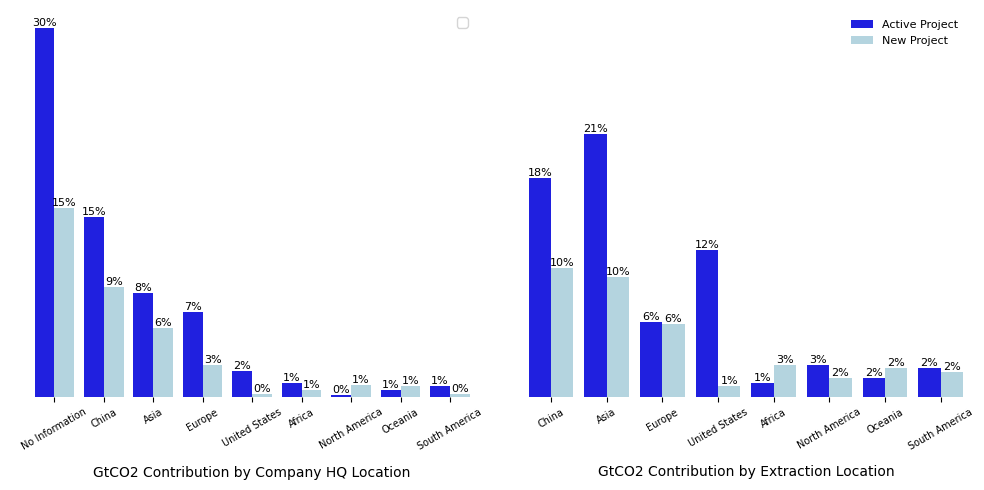

In [85]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

fig.patch.set_facecolor('none')
ax[0].set_facecolor('none')
ax[1].set_facecolor('none')

ax1 = sns.barplot(x='Zone', y='Share', hue='New Project', data=sorted_GtCO2_dist_company, ax=ax[0], errorbar=None, palette=['blue', 'lightblue'])

x_labels_ax1 = [tick.get_text() for tick in ax1.get_xticklabels()]
x_indices = {label: i for i, label in enumerate(x_labels_ax1)}

sorted_data_ax2 = sorted_GtCO2_dist_site.copy()
sorted_data_ax2['Zone_Index'] = sorted_data_ax2['Zone'].map(x_indices)

sorted_data_ax2 = sorted_data_ax2.sort_values(by='Zone_Index')

ax2 = sns.barplot(x='Zone', y='Share', hue='New Project', data=sorted_data_ax2, ax=ax[1], errorbar=None, palette=['blue', 'lightblue'])

# ax1.yaxis.set_major_formatter('{x:.0%}')
# ax2.yaxis.set_major_formatter('{x:.0%}')

# ax1.set_title('GtCO2 Distribution by Company HQ', fontsize=10, pad=12)
# ax2.set_title('GtCO2 Distribution by Site of Extraction', fontsize=10, pad=12)

ax1.set_xlabel('GtCO2 Contribution by Company HQ Location', fontsize=10, labelpad=10)
ax2.set_xlabel('GtCO2 Contribution by Extraction Location', fontsize=10, labelpad=10)

ax1.set_ylabel(" ")
ax2.set_ylabel(" ")

ax2.legend(loc='upper right', fontsize=10, frameon=False)
ax1.legend([])

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30, fontsize = 7)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, fontsize = 7)

ax1.set_yticklabels([])
ax2.set_yticklabels([])

ax1.yaxis.set_ticks([])
ax2.yaxis.set_ticks([])

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# fig.text(0.5, -0.05, '% Share of GtCO2 among Company HQ/ Site of Extraction by Project Status', ha='center', fontsize=12)

# Add labels at the end of each bar
for container in ax1.containers:
    ax1.bar_label(container, label_type='edge', fontsize=8, fmt='%d%%', labels=[f"{int(round(val*100))}%" for val in container.datavalues])

for container in ax2.containers:
    ax2.bar_label(container, label_type='edge', fontsize=8, fmt='%d%%', labels=[f"{int(round(val*100))}%" for val in container.datavalues])

# Change legend labels to text
handles, labels = ax2.get_legend_handles_labels()
new_labels = ['Active Project', 'New Project']
ax2.legend(handles, new_labels, loc='upper right', fontsize=8, frameon=False)

plt.tight_layout()
plt.show()


In [ ]:
# custom_palette = sns.color_palette(['blue', 'lightblue', 'orange', 'lightsalmon'])

# fig = plt.figure(figsize=(12, 8))

# ax = sns.catplot(x='Zone', y='Share', hue='New Project', data=sorted_GtCO2_dist, col='Label', kind='bar',
#                  palette=custom_palette, height=10)

# # Iterate over each subplot
# for ax_subplot in ax.axes.flat:
#     # Stack the bars
#     for container in ax_subplot.containers:
#         ax_subplot.bar_label(container, label_type='edge', fontsize=12)
#     # Rotate x tick labels
#     ax_subplot.set_xticklabels(ax_subplot.get_xticklabels(), rotation=45)

# # Show the plot
# plt.tight_layout()
# plt.show()

### Investment Flow by Zone, from Bank to Company

#### Merging bank_comp connection to their respective country (of banks & companies)

In [86]:
bank_comp['Grand Total'].sum()
# Total Investment through the years = 1,069,369,072,677.9812

1069369072677.9812

In [87]:
bank_comp_melt_ttl = pd.read_csv('../../dev_data/bank_comp_melt_ttl.csv')

In [88]:
bank_comp_bcc = bank_comp_melt_ttl.merge(bank_info, how = "left", left_on = "Bank", right_on= "Bank Name")

In [89]:
bank_comp_bcc = bank_comp_bcc[['Bank', 'Company', 'Amount','Bank_Country']]
bank_comp_bcc['Amount'].sum()
# 'Grand Total' was a label of the final sum. Replaced by 'Amount' refering to grand total amount invested from 2016 - 2022

1069369072677.9812

In [90]:
bank_comp_bcc_ccc = bank_comp_bcc.merge(company_info_sliced, how='left', left_on='Company', right_on='Company_name')

In [91]:
bank_comp_bcc_ccc['Amount'].sum()

1069369072677.9812

In [95]:
bank_comp_bcc_ccc[bank_comp_bcc_ccc['Company_name'].isnull()]

,Bank,Company,Amount,Bank_Country,Company_name,Company_Country
11,Agricultural Bank of China,Hebei Construction & Investment Group Co Ltd,"329,412,531",China,NaN,NaN
64,Bank of China,Hebei Construction & Investment Group Co Ltd,"209,281,384",China,NaN,NaN
110,Bank of Communications,Hebei Construction & Investment Group Co Ltd,"134,627,625",China,NaN,NaN
196,China CITIC Bank,Hebei Construction & Investment Group Co Ltd,"225,961,665",China,NaN,NaN
210,China Construction Bank,Hebei Construction & Investment Group Co Ltd,"157,802,167",China,NaN,NaN
212,China Construction Bank,Anhui Province Wanbei Coal-Electricity Group C...,"16,837,705",China,NaN,NaN
239,China Everbright Bank,Hebei Construction & Investment Group Co Ltd,"39,070,250",China,NaN,NaN
241,China Everbright Bank,Anhui Province Wanbei Coal-Electricity Group C...,"35,347,250",China,NaN,NaN
255,China Merchants Bank,Hebei Construction & Investment Group Co Ltd,"34,652,500",China,NaN,NaN
274,China Minsheng Bank,Hebei Construction & Investment Group Co Ltd,"19,603,875",China,NaN,NaN


##### var - bank_comp_bcc_ccc_2

In [96]:
bank_comp_bcc_ccc_2 = bank_comp_bcc_ccc.copy()

In [97]:
nan_data_2 = [
    "State Grid Corp of China: China",
    "China National Petroleum Corporation (CNPC): China",
    "China Huadian Corp Ltd: China",
    "Beijing Energy Holding Co Ltd: China",
    "Shandong Energy Co Ltd: China",
    "China Energy Investment Corp Ltd: China",
    "China Huaneng Group Co Ltd: China",
    "Jinneng Holding Group Co Ltd: China",
    "China Datang Corp: China",
    "Shenergy Group Co Ltd: China",
    "Guangdong Hengjian Investment Holding Co Ltd: China",
    "Hebei Construction & Investment Group Co Ltd: China",
    "Huayang New Material Technology Group Co Ltd: China",
    "China ZhenHua Oil Co Ltd: China",
    "Inner Mongolia Mengtai Group Co Ltd: China",
    "Inpex Corp: Japan",
    "Shaanxi Yanchang Petroleum Group Co Ltd: China",
    "Jizhong Energy Group Co Ltd: China",
    "Shougang Group Co Ltd: China",
    "Lu'an Chemical Group Co Ltd: China",
    "Zhejiang Provincial Energy Group Co Ltd: China",
    "Hubei Yihua Chemical Industry Co Ltd: China",
    "Glencore PLC: Switzerland",
    "BHP Group Ltd: Australia",
    "Exxon Mobil Corp: United States",
    "Shell PLC: United Kingdom",
    "AGL Energy Ltd: Australia",
    "TotalEnergies SE: France",
    "Delek Group Ltd: Israel",
    "POSCO Holdings Inc: South Korea",
    "Chevron Corp: United States",
    "Petróleo Brasileiro SA – Petrobras: Brazil",
    "Petróleos Mexicanos (PEMEX): Mexico",
    "Evraz PLC: United Kingdom",
    "ITOCHU Corp: Japan",
    "Peabody Energy Corp: United States",
    "PPL Corp: United States",
    "Mitsubishi Corp: Japan",
    "Suncor Energy Inc: Canada",
    "Teck Resources Ltd: Canada",
    "Occidental Petroleum Corp: United States",
    "Pertamina Persero PT: Indonesia",
    "Shaanxi Investment Group Co Ltd: China",
    "Gazprom PJSC: Russia",
    "Guangdong Hanjian Investment Co Ltd: China",
    "Shaanxi Yulin Energy Group Co Ltd: China",
    "Inner Mongolia Yitai Investment Co Ltd: China",
    "Shenmu City State-Owned Assets Operation Co: China",
    "China COSCO Shipping Corp Ltd: China",
    "Kailuan Group Ltd Liability Corp: China",
    "Shaanxi Coal and Chemical Industry Group Co Ltd: China",
    "Shanxi Coking Coal Group Co Ltd: China",
    "Tianjin Energy Investment Co Ltd: China",
    "Xin Jiang Guang Hui Industry Investment Group Co Ltd: China",
    "China Coal Xinji Energy Co Ltd: China",
    "Arch Resources Inc: United States",
    "Harbour Energy PLC: United Kingdom",
    "NTPC Ltd: India",
    "Indonesia Asahan Aluminium Persero PT: Indonesia",
    "Kuwait Petroleum Corp: Kuwait",
    "Anhui Province Wanbei Coal-Electricity Group Co Ltd: China",
    "Elion Resources Group Ltd: China",
    "Alliance Resource Partners LP: United States",
    "Bulgarian Energy Holding EAD: Bulgaria",
    "Exxaro Resources Ltd: South Africa",
    "Indian Oil Corp Ltd: India",
    "Indika Energy Tbk PT: Indonesia",
    "Yangcheng County Yangtai Group Industrial Co Ltd: China",
    "Titan Infra Energy PT: Indonesia",
    "Electricity Generating PCL: Thailand",
    "Bayan Resources Tbk PT: Indonesia",
    "Sojitz Corp: Japan",
    "Thungela Resources Ltd: South Africa",
    "Rosneftegaz AO: Russia",
    "Coal India Ltd: India",
    "Reliance Power Ltd: India"
]

nan_data_2 = [line.split(":") for line in nan_data_2]
nan_data_2 = pd.DataFrame(nan_data_2, columns=['Company','Company_Country'])
nan_data_2 = nan_data_2.applymap(str.strip)

In [101]:
def lookup_country_2(row):
    matching_rows = nan_data_2[nan_data_2['Company'] == row['Company']]
    if matching_rows.empty:
        return row['Company_Country']
    else:
        return matching_rows['Company_Country'].iloc[0]

In [102]:
bank_comp_bcc_ccc_2['Company_Country'] = bank_comp_bcc_ccc.apply(lookup_country_2, axis=1)

In [104]:
bank_comp_bcc_ccc_2 = bank_comp_bcc_ccc_2[['Bank', 'Company', 'Amount', 'Bank_Country','Company_Country']]

##### file - connexion_carbonbombs_company_companycountry_bankcountry

In [106]:
# bank_comp_bcc_ccc_2.to_csv('../../dev_data/connexion_carbonbombs_company_companycountry_bankcountry.csv')

In [ ]:
# bank_comp_bcc_ccc_2 = pd.read_csv("../../dev_data/connexion_carbonbombs_company_companycountry_bankcountry.csv")

In [105]:
bank_comp_bcc_ccc_3 = bank_comp_bcc_ccc_2.groupby(by = ['Bank', 'Company','Bank_Country','Company_Country'], dropna = False).sum().reset_index()

In [107]:
bank_comp_bcc_ccc_3['Amount'].sum()

1069369072677.9814

In [108]:
bank_comp_bcc_ccc_3.head()

,Bank,Company,Bank_Country,Company_Country,Amount
0,ANZ,AGL Energy Ltd,Australia,Australia,"116,841,313"
1,ANZ,BHP Group Ltd,Australia,Australia,"60,357,143"
2,ANZ,Exxon Mobil Corp,Australia,United States,"400,000,000"
3,ANZ,Glencore PLC,Australia,Switzerland,"424,747,395"
4,ANZ,Inpex Corp,Australia,Japan,"3,612,244,230"


In [109]:
bank_comp_bcc_ccc_3['Bank_Zone'] = bank_comp_bcc_ccc_3['Bank_Country'].map(country_to_zone)
bank_comp_bcc_ccc_3['Company_Zone'] = bank_comp_bcc_ccc_3['Company_Country'].map(country_to_zone)

In [113]:
bank_comp_bcc_ccc_3

,Bank,Company,Bank_Country,Company_Country,Amount,Bank_Zone,Company_Zone
0,ANZ,AGL Energy Ltd,Australia,Australia,"116,841,313",Oceania,Oceania
1,ANZ,BHP Group Ltd,Australia,Australia,"60,357,143",Oceania,Oceania
2,ANZ,Exxon Mobil Corp,Australia,United States,"400,000,000",Oceania,United States
3,ANZ,Glencore PLC,Australia,Switzerland,"424,747,395",Oceania,Europe
4,ANZ,Inpex Corp,Australia,Japan,"3,612,244,230",Oceania,Asia
5,ANZ,Shell PLC,Australia,United Kingdom,"388,000,000",Oceania,Europe
6,ANZ,State Grid Corp of China,Australia,China,"358,913,613",Oceania,China
7,ANZ,TotalEnergies SE,Australia,France,"341,250,503",Oceania,Europe
8,ANZ,Zhejiang Provincial Energy Group Co Ltd,Australia,China,"50,000,000",Oceania,China
9,Agricultural Bank of China,Beijing Energy Holding Co Ltd,China,China,"1,201,041,613",China,China


##### file - bank_comp_country_zone_value

In [111]:
bank_comp_bcc_ccc_3.to_csv('../../dev_data/bank_comp_country_zone_values.csv')

#### Graph - Sankey

##### def - draw_sankey

In [292]:
def draw_sankey_dym(df, text, source, target, values, width, height):
    unique_source_target = list(pd.unique(df[[source, target]].values.ravel('K')))
    mapping_dict = {k: v for v, k in enumerate(unique_source_target)}
    df[source] = df[source].map(mapping_dict)
    df[target] = df[target].map(mapping_dict)
    sankey_dict = df.to_dict(orient='list')

    node_colors = ['#99ccff', '#ff9999', '#99ff99', '#ffff99', '#ffcc99', '#cc99ff',
                   '#99ccff', '#ff9999', '#99ff99', 'darkgrey', '#ffff99', '#ffcc99', 'darkgray', '#cc99ff']
    
    link_colors = ['silver', 'lightgray', 'gainsboro']

    node_colors_cus = {
                        'Asia_Bank':'tomato',
                        'China_Bank':'indianred',
                        'Europe_Bank':'slateblue',
                        'North America_Bank':'orchid',
                        'Oceania_Bank':'turquoise',
                        'United States_Bank':'tan',
                        'Asia_Company':'tomato',
                        'China_Company':'indianred',
                        'Europe_Company':'slateblue',
                        'North America_Company':'orchid',
                        'Oceania_Company':'turquoise',
                        'South America_Company':'gray',
                        'United States_Company':'tan',
                        'Africa_Company':'gray',
                        'Africa_CBB': 'gray',
                        'No Information' : 'gray',
                        'Asia_CBB' : 'tomato',
                        'China_CBB': 'indianred',
                        'North America_CBB': 'orchid',
                        'Oceania_CBB':'turquoise',
                        'South America_CBB':'gray',
                        'Europe_CBB':'slateblue',
                        'United States_CBB':'tan'}
    
    node_data = dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0),
        label=unique_source_target,
        color = [node_colors_cus.get(node, 'gray') for node in unique_source_target]
        # color=[random.choice(node_colors) for _ in unique_source_target],
    )
    
    link_data = dict(
        source=df[source],
        target=df[target],
        value=df[values],
        color=[random.choice(link_colors) for _ in range(len(df))],
    )

    fig = go.Figure(data=[go.Sankey(node=node_data, link=link_data)])

    fig.update_layout(title_text=text, 
                    font_size=10,
                    width=width,
                    height=height )
    fig.show()

##### Graph - B>C

In [339]:
sankey_bank_comp = bank_comp_bcc_ccc_3.copy()

In [340]:
sankey_bank_comp = sankey_bank_comp[['Bank_Zone', 'Company_Zone', 'Amount']]

In [341]:
sankey_bank_comp_pv = pd.pivot_table(bank_comp_bcc_ccc_3, values=['Amount'], index=['Bank_Zone', 'Company_Zone'], aggfunc='sum').reset_index()
sankey_bank_comp_pv['Bank_Zone_Label'] = sankey_bank_comp_pv['Bank_Zone'] + '_Bank'
sankey_bank_comp_pv['Company_Zone_Label'] = sankey_bank_comp_pv['Company_Zone'] + '_Company'

In [342]:
draw_sankey_dym(sankey_bank_comp_pv, 'Investment Flow from Bank to Company', 'Bank_Zone_Label', 'Company_Zone_Label', 'Amount', 800, 600)

### Investment Flow by Entity

#### Flows between Entities

In [ ]:
# cb_comp_co2_ctry_2 = pd.read_csv('../../dev_data/connexion_carbonbombs_company_companycountry.csv')

In [149]:
comp_to_cbb = cb_comp_co2_ctry_2[['Company','Carbon_bomb_name', 'GtCO2_by_Company']]
bank_to_comp = bank_comp_bcc_ccc_3[['Bank','Company','Amount']]

In [150]:
n = 1000000000
comp_to_cbb['Values_Norm'] = comp_to_cbb['GtCO2_by_Company'] * n

In [152]:
bank_to_comp['Values_Norm'] = bank_to_comp['Amount']

In [153]:
comp_to_cbb.columns = ['Source', 'Target', 'Values', 'Values_Norm']
bank_to_comp.columns = ['Source', 'Target', 'Values','Values_Norm']
bank_to_comp_to_cbb = pd.concat([bank_to_comp, comp_to_cbb], axis=0)
# Full names/ entitites

In [154]:
bank_to_comp['Values'].sum()

1069369072677.9814

In [156]:
comp_to_cbb['Values_Norm'].sum()

1182272634207.0

In [162]:
b2c2cbb_source = bank_to_comp_to_cbb.merge(entity_zone, how='left', left_on='Source', right_on='Entity')
b2c2cbb_source = b2c2cbb_source[['Source', 'Target', 'Values', 'Values_Norm', 'Zone']]
b2c2cbb_source.columns = ['Source', 'Target', 'Values', 'Values_Norm', 'ZoneS']

In [163]:
b2c2cbb_source['Values'].sum()

1069369073860.2539

In [164]:
b2c2cbb_source.tail(11)

,Source,Target,Values,Values_Norm,ZoneS
1647,New Project,Central Arabian Offshore,1,"1,411,444,785",NaN
1648,New Project,Central Arabian Offshore,2,"2,122,142,874",NaN
1649,New Project,Central Arabian Offshore,7,"6,860,051,661",NaN
1650,No informations on company,Central Arabian Onshore,3,"2,607,423,632",NaN
1651,No informations on company,Central Arabian Onshore,4,"3,597,522,951",NaN
1652,No informations on company,Central Arabian Onshore,2,"2,217,231,619",NaN
1653,No informations on company,Central Arabian Onshore,4,"4,359,973,713",NaN
1654,No informations on company,Eagle Ford Shale,5,"5,068,029,400",NaN
1655,No informations on company,Eagle Ford Shale,6,"5,924,247,947",NaN
1656,New Project,La Luna Shale,2,"1,616,788,836",NaN


In [165]:
b2c2cbb_source_top = b2c2cbb_source.iloc[:1647,]
b2c2cbb_source_bot = b2c2cbb_source.iloc[1647:,]
b2c2cbb_source_bot.tail()

,Source,Target,Values,Values_Norm,ZoneS
1653,No informations on company,Central Arabian Onshore,4,"4,359,973,713",NaN
1654,No informations on company,Eagle Ford Shale,5,"5,068,029,400",NaN
1655,No informations on company,Eagle Ford Shale,6,"5,924,247,947",NaN
1656,New Project,La Luna Shale,2,"1,616,788,836",NaN
1657,New Project,La Luna Shale,1,"1,090,522,015",NaN


In [168]:
b2c2cbb_source_top_target = b2c2cbb_source_top.merge(entity_zone, how='left', left_on='Target', right_on='Entity')
b2c2cbb_source_top_target = b2c2cbb_source_top_target[['Source', 'Target', 'Values','Values_Norm', 'ZoneS', 'Zone']]
b2c2cbb_source_top_target.columns = ['Source', 'Target', 'Values', 'Values_Norm', 'ZoneS', 'ZoneT']

In [169]:
b2c2cbb_source_top_target.tail()

,Source,Target,Values,Values_Norm,ZoneS,ZoneT
1642,Korean Gas Corporation,Zubair,0,"315,709,227",Asia,Asia
1643,Missan Oil Company,Zubair,0,"419,826,100",Asia,Asia
1644,New project,Zuluf (CR in field),4,"3,535,052,229",NaN,Asia
1645,New project,Zuluf (expansion),2,"1,833,213,347",NaN,Asia
1646,No informations on company,Zuluf,2,"2,449,978,206",NaN,Asia


In [170]:
b2c2cbb_source_bot['ZoneT'] = 'Asia'
b2c2cbb_source_bot

,Source,Target,Values,Values_Norm,ZoneS,ZoneT
1647,New Project,Central Arabian Offshore,1,"1,411,444,785",NaN,Asia
1648,New Project,Central Arabian Offshore,2,"2,122,142,874",NaN,Asia
1649,New Project,Central Arabian Offshore,7,"6,860,051,661",NaN,Asia
1650,No informations on company,Central Arabian Onshore,3,"2,607,423,632",NaN,Asia
1651,No informations on company,Central Arabian Onshore,4,"3,597,522,951",NaN,Asia
1652,No informations on company,Central Arabian Onshore,2,"2,217,231,619",NaN,Asia
1653,No informations on company,Central Arabian Onshore,4,"4,359,973,713",NaN,Asia
1654,No informations on company,Eagle Ford Shale,5,"5,068,029,400",NaN,Asia
1655,No informations on company,Eagle Ford Shale,6,"5,924,247,947",NaN,Asia
1656,New Project,La Luna Shale,2,"1,616,788,836",NaN,Asia


In [265]:
b2c2cbb_source_target = pd.concat([b2c2cbb_source_top_target, b2c2cbb_source_bot], axis=0)

In [266]:
b2c2cbb_source_target.loc[:849,'Values'].sum()

1069369072678.5757

In [267]:
b2c2cbb_source_target.loc[849:,'Values'].sum()

1182.272634207

In [268]:
b2c2cbb_source_target['LabelS']= b2c2cbb_source_target['ZoneS'] + '_Bank'
b2c2cbb_source_target.loc[849:,'LabelS'] = b2c2cbb_source_target['ZoneS'] + '_Company'

In [269]:
b2c2cbb_source_target['LabelT']= b2c2cbb_source_target['ZoneT'] + '_Company'
b2c2cbb_source_target.loc[849:,'LabelT'] = b2c2cbb_source_target['ZoneT'] + '_CBB'

In [270]:
b2c2cbb_source_target['LabelT'].value_counts()

China_CBB                375
China_Company            340
Asia_CBB                 198
Europe_Company           166
Asia_Company             144
United States_Company    108
Europe_CBB                75
South America_CBB         41
Africa_CBB                38
Oceania_CBB               34
North America_Company     33
United States_CBB         27
Oceania_Company           23
North America_CBB         21
South America_Company     18
Africa_Company             2
Name: LabelT, dtype: int64

In [271]:
b2c2cbb_source_target.isnull().sum()

Source           0
Target           0
Values           1
Values_Norm      1
ZoneS          223
ZoneT           15
LabelS         223
LabelT          15
dtype: int64

In [272]:
# b2c2cbb_source_target[b2c2cbb_source_target['Values'].isnull()]
b2c2cbb_source_target.loc[:849, 'Values'].sum()

1069369072678.5757

##### var - b2c2cbb_source_target / entity_flow

In [273]:
b2c2cbb_source_target.tail()

,Source,Target,Values,Values_Norm,ZoneS,ZoneT,LabelS,LabelT
1653,No informations on company,Central Arabian Onshore,4,"4,359,973,713",NaN,Asia,NaN,Asia_CBB
1654,No informations on company,Eagle Ford Shale,5,"5,068,029,400",NaN,Asia,NaN,Asia_CBB
1655,No informations on company,Eagle Ford Shale,6,"5,924,247,947",NaN,Asia,NaN,Asia_CBB
1656,New Project,La Luna Shale,2,"1,616,788,836",NaN,Asia,NaN,Asia_CBB
1657,New Project,La Luna Shale,1,"1,090,522,015",NaN,Asia,NaN,Asia_CBB


In [274]:
b2c2cbb_source_target['Sheet_Info'] = 'Company_to_CBB'
b2c2cbb_source_target.loc[:848, 'Sheet_Info'] = 'Bank_to_Company'

In [275]:
b2c2cbb_source_target.loc[844:850,]

,Source,Target,Values,Values_Norm,ZoneS,ZoneT,LabelS,LabelT,Sheet_Info
844,Wells Fargo,Shell PLC,"1,742,590,001","1,742,590,001",United States,Europe,United States_Bank,Europe_Company,Bank_to_Company
845,Westpac,BHP Group Ltd,"60,357,143","60,357,143",Oceania,Oceania,Oceania_Bank,Oceania_Company,Bank_to_Company
846,Westpac,Indian Oil Corp Ltd,"1,019,700,000","1,019,700,000",Oceania,Asia,Oceania_Bank,Asia_Company,Bank_to_Company
847,Westpac,Inpex Corp,"521,769,230","521,769,230",Oceania,Asia,Oceania_Bank,Asia_Company,Bank_to_Company
848,Westpac,State Grid Corp of China,"247,360,195","247,360,195",Oceania,China,Oceania_Bank,China_Company,Bank_to_Company
849,Limited,ACG (Azeri-Chirag-Guneshli Deep Water),1,"594,375,119",NaN,Asia,NaN,Asia_CBB,Company_to_CBB
850,Azerbaijan,ACG (Azeri-Chirag-Guneshli Deep Water),0,"192,590,821",Asia,Asia,Asia_Company,Asia_CBB,Company_to_CBB


In [276]:
b2c2cbb_source_target = b2c2cbb_source_target.fillna('No Information')

In [277]:
b2c2cbb_source_target[b2c2cbb_source_target['Values_Norm'] == 'No Information']
b2c2cbb_source_target.loc[1502, 'Values'] = 0
b2c2cbb_source_target.loc[1502, 'Values_Norm'] = 0

##### file - bank_to_company_to_cbb_flow_zone_label

In [278]:
# b2c2cbb_source_target.to_csv('../../dev_data/bank_to_company_to_cbb_flow_zone_label.csv')

In [332]:
b2c2cbb_source_target = pd.read_csv('../../dev_data/bank_to_company_to_cbb_flow_zone_label.csv')

##### Graph - B>C>CBB

In [333]:
sankey_entity_pv = pd.pivot_table(b2c2cbb_source_target, values=['Values_Norm'], index=['LabelS', 'LabelT'], aggfunc='sum').reset_index()

In [334]:
draw_sankey_dym(sankey_entity_pv, 'Investment Flow from Bank To Company and CO2 contribution by Companies to CBB Projects', 'LabelS', 'LabelT', 'Values_Norm', 800, 600)

##### Graph - B>CBB

In [329]:
comp_to_cbb_source_target = b2c2cbb_source_target.loc[849:,]

In [330]:
sankey_comp_cbb_pv = pd.pivot_table(comp_to_cbb_source_target, values=['Values'], index=['LabelS', 'LabelT'], aggfunc='sum').reset_index()

In [331]:
draw_sankey_dym(sankey_comp_cbb_pv, 'Company Contribution of GtCO2 to CBB', 'LabelS', 'LabelT', 'Values', 800, 600)

#### Chord Exploration

In [311]:
sankey_bank_comp_pv.head()

,Bank_Zone,Company_Zone,Amount,Bank_Zone_Label,Company_Zone_Label
0,Asia,Asia,"20,127,992,881",Asia_Bank,Asia_Company
1,Asia,China,"2,073,512,161",Asia_Bank,China_Company
2,Asia,Europe,"11,119,697,440",Asia_Bank,Europe_Company
3,Asia,North America,"10,186,629,648",Asia_Bank,North America_Company
4,Asia,Oceania,"181,071,429",Asia_Bank,Oceania_Company


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

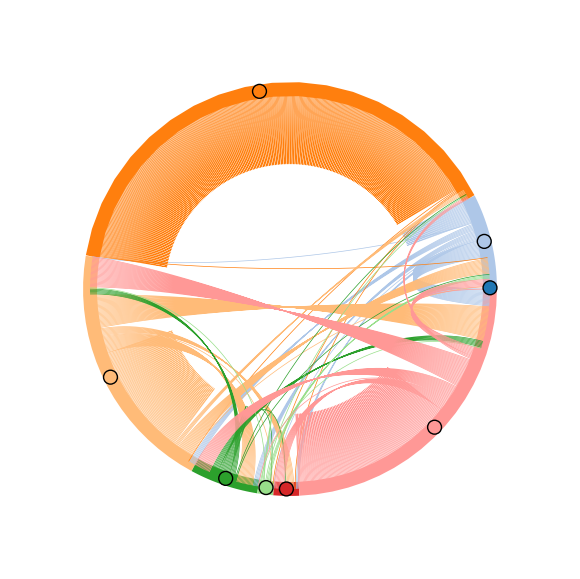

In [317]:
import holoviews as hv
from holoviews import opts, dim
hv.extension('matplotlib')

chord = hv.Chord(sankey_bank_comp_pv, ['Bank_Zone', 'Company_Zone'], 'Amount')
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('Bank_Zone').str(), labels='source',
               node_color=dim('index').str())
)

hv.output(size=200)
hv.render(chord)
# hv.save(chord, 'chord_diagram.html')